In [1]:
from binarytoydata import *
from dummymodels import *
%load_ext autoreload
import pandas as pd
import torch.distributions as dist
import torch
import pandas as pd
import numpy as np
import sklearn
import itertools
from binary_data_tools import *

# Setup
- z, x0, x1, t and y all binary
- two x so that the data is identifiable by Pearl's method
- Expectation value in ELBO calculated exactly since z has just one of two values
- VAE prior on z is P(z) = 0.5
- z->x0, z->x1, z->t, z->y|t=0 and z->y|t=1 networks are just logistic regression since it should be enough
- (x0,x1,t,y)->z is 8 different logistic regressions where the regression is is done on y for all different (x0,x1,t) combinations
    - So the actual expression is something like $q_{000}(z|y) (1-x_0)(1-x_1)(1-t) + q_{001}(z|y) (1-x_0)(1-x_1)t ...$ 
    - Should be enough in principle to represent p(z|x0,x1,t,y)
- Questions:
    - Do we get the right ATE?
    - Do we get the right P(z,x,t,y)?
    - Does the entire method break if the data generating process doesn't match with prior P(z)?

# Experiment 1, P_z = 0.5

In [2]:
num_samples = 10000
z_expectation = torch.Tensor([0.5])
x_expectations = torch.Tensor([[0.1,0.9],
                              [0.9,0.1]])
x_dim = len(x_expectations)
t_expectations = torch.Tensor([[0.3,0.7]])
y_expectations = torch.Tensor([[0.85,0.9,0.1,0.95]])
#df = binary_data_df(num_samples, z_expectation, x_expectations, t_expectations, y_expectations)

In [3]:
"""Get the convenience function and define the corresponding dataframe"""
calculate_prob = generate_calculate_prob(z_expectation, x_expectations, t_expectations, y_expectations)
prob_df = pd.DataFrame([c + (calculate_prob(c[0], c[1:3], c[3], c[4]),) for c in itertools.product([0,1],repeat=5)], 
                       columns=['z'] + ['x{}'.format(i) for i in range(x_dim)] + ['t', 'yf', 'P'])

In [4]:
"""Calculating the true ATE and the ATE we get by adjusting just for the proxies"""
print("True and proxy based ATEs: {:.3f}, {:.3f}".format(calculate_true_ate(prob_df), 
    calculate_proxy_ate(prob_df)))

True and proxy based ATEs: 0.450, 0.418


In [6]:
"""Functions that do P(y=1|X,t) and P(y=1|t) predictions perfectly"""
%autoreload 2
p_y_xt_f = generate_p_y_xt(prob_df)
p_t_x_f = generate_p_t_x(prob_df)
#q_y_xt_f = generate_q_y_xt(df)
#q_t_x_f = generate_q_t_x(df)

In [9]:
"""Run this before the first time running the next cell"""
datasizes = [1000,2000,6000,10000,20000]
i = 0
j = 0
dfs = [[0 for j in range(10)] for i in range(len(datasizes))]
models = [[0 for j in range(10)] for i in range(len(datasizes))]

In [10]:
"""Runs the model for different datasets multiple times"""
%autoreload 2
BATCH_SIZE = 1000
datasize_times = 10
device = 'cpu'
#what results are we gathering?

#Simulating datasets and training models
while i < len(datasizes):
    #dfs.append([])
    #models.append([])
    while j < datasize_times:
        num_samples = datasizes[i]
        print("Training data size {}, run {}".format(num_samples, j+1))
        df = binary_data_df(num_samples, z_expectation, x_expectations, t_expectations, y_expectations)
        dataset = BinaryDataset(df)
        dataloader = BinaryDataLoader(dataset, validation_split=0.0)
        train_loader, test_loader = dataloader.get_loaders(batch_size=BATCH_SIZE)
        #dummy test loader
        test_loader, _ = BinaryDataLoader(BinaryDataset(df[:1]), validation_split=0.0).get_loaders(batch_size=1)
        #Running the model
        model = run_cevae(num_epochs=50, lr_start=0.3, lr_end=0.1,
                train_loader=train_loader, test_loader=test_loader, input_dim=2,
                plot_curves=False, print_logs=False, device=device)
    
        dfs[i][j] = df
        models[i][j] = model
        
        torch.save(model.state_dict(), "./dummy_data/model_{}_{}".format(num_samples,j))
        df.to_pickle("./dummy_data/data_{}_{}".format(num_samples,j))
        
        x = torch.Tensor(df[['x0','x1']].values).to(device)
        print("Estimated ATE: {}".format(modelITE(model, x, p_y_xt_f, p_t_x_f).mean()))
        
        j += 1
    j = 0
    i += 1

Training data size 1000, run 1
Estimated ATE: 0.45423194766044617
Training data size 1000, run 2
Estimated ATE: 0.4356464445590973
Training data size 1000, run 3
Estimated ATE: 0.4364688992500305
Training data size 1000, run 4
Estimated ATE: 0.455522358417511
Training data size 1000, run 5
Estimated ATE: 0.415048211812973
Training data size 1000, run 6
Estimated ATE: 0.4189612865447998
Training data size 1000, run 7
Estimated ATE: 0.42437586188316345
Training data size 1000, run 8
Estimated ATE: 0.44249293208122253
Training data size 1000, run 9
Estimated ATE: 0.43653813004493713
Training data size 1000, run 10
Estimated ATE: 0.4339786171913147
Training data size 2000, run 1
Estimated ATE: 0.4673721492290497
Training data size 2000, run 2
Estimated ATE: 0.44041529297828674
Training data size 2000, run 3
Estimated ATE: 0.4734886586666107
Training data size 2000, run 4
Estimated ATE: 0.42266684770584106
Training data size 2000, run 5
Estimated ATE: 0.4323132634162903
Training data size 2

In [11]:
#Calculating results from the models
model_ITEs_1 = [[] for n in range(len(datasizes))]
model_ITEs_2 = [[] for n in range(len(datasizes))]
model_ATEs_1 = [[] for n in range(len(datasizes))]
model_ATEs_2 = [[] for n in range(len(datasizes))]
model_ATEs_3 = [[] for n in range(len(datasizes))]
proxy_ITEs = [[] for n in range(len(datasizes))]
proxy_ATEs = [[] for n in range(len(datasizes))]
dists_VAE = [[] for n in range(len(datasizes))]
dists_data = [[] for n in range(len(datasizes))]
dists_true = [[] for n in range(len(datasizes))]

for n in range(len(datasizes)):
    for i in range(datasize_times):
        #P(y=1|X,t) and P(t=1|X) estimates directly from the data
        df = dfs[n][i]
        model = models[n][i]
        q_y_xt_f = generate_q_y_xt(df)
        q_t_x_f = generate_q_t_x(df)

        #Getting the ITE and ATE estimates
        x = torch.Tensor(df[['x0','x1']].values)
        p_y_xt_f(x[0][0].item(),x[0][1].item(),1)
        model_ITEs_1[n].append(modelITE(model, x, p_y_xt_f, p_t_x_f))
        model_ITEs_2[n].append(modelITE(model, x, q_y_xt_f, q_t_x_f))
        proxy_ITEs[n].append(proxyITE(x, q_y_xt_f))
        model_ATEs_1[n].append(model_ITEs_1[n][i].mean())
        model_ATEs_2[n].append(model_ITEs_2[n][i].mean())
        proxy_ATEs[n].append(proxy_ITEs[n][i].mean())
        z_sample = dist.Bernoulli(torch.Tensor([0.5])).sample((50000,))
        p_y_do1_model = torch.sigmoid(model.decoder.y1_nn(z_sample)).mean()
        p_y_do0_model =torch.sigmoid(model.decoder.y0_nn(z_sample)).mean()
        model_ATEs_3[n].append(p_y_do1_model - p_y_do0_model)

        #Getting probability distribution estimates
        zs, xs, ts, ys = model.decoder.sample(1000000)
        sample_data = torch.cat([zs, xs,ts,ys],axis=1)
        dist_VAE, dist_data, dist_true = getJointDistributions(sample_data, df[['z','x0','x1','t','yf']],prob_df)
        #Choosing the assignment for z
        dist_VAE_1 = dist_VAE
        dist_VAE_2 = dist_VAE.copy()
        dist_VAE_2.z = 1-dist_VAE_2.z
        dist_VAE_2.sort_values(by=['z','x0','x1','t','yf'], inplace=True, ignore_index=True)
        err_1 = (dist_VAE_1.P - dist_true.P).abs().sum()
        err_2 = (dist_VAE_2.P - dist_true.P).abs().sum()
        if err_1 < err_2:
            dists_VAE[n].append(dist_VAE_1)
        else:
            dists_VAE[n].append(dist_VAE_2)
        dists_data[n].append(dist_data)
        dists_true[n].append(dist_true)

Text(0.5, 1.0, 'sum(|P_data(z,x,t,y) - P_true(z,x,t,y)|)')

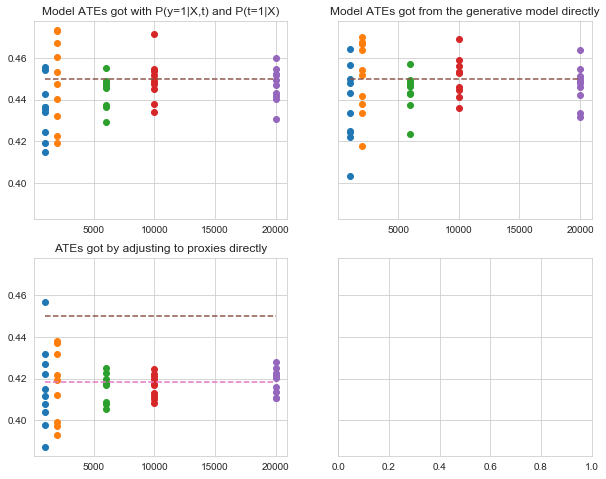

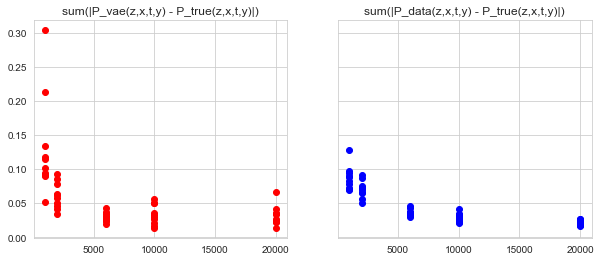

In [12]:
"""Plot results"""
fig, ax = plt.subplots(2, 2, figsize=(10,8), sharey=True)
for n in range(len(datasizes)):
    ax[0,0].plot(datasize_times*[datasizes[n]], model_ATEs_1[n], 'o')
ax[0,0].plot([datasizes[0], datasizes[-1]], 2*[calculate_true_ate(prob_df)], '--')
ax[0,0].set_title("Model ATEs got with P(y=1|X,t) and P(t=1|X)")

for n in range(len(datasizes)):
    ax[0,1].plot(datasize_times*[datasizes[n]], model_ATEs_3[n], 'o')
ax[0,1].plot([datasizes[0], datasizes[-1]], 2*[calculate_true_ate(prob_df)], '--')
ax[0,1].set_title("Model ATEs got from the generative model directly")

for n in range(len(datasizes)):
    ax[1,0].plot(datasize_times*[datasizes[n]], proxy_ATEs[n], 'o')
ax[1,0].plot([datasizes[0], datasizes[-1]], 2*[calculate_true_ate(prob_df)], '--')
ax[1,0].plot([datasizes[0], datasizes[-1]], 2*[calculate_proxy_ate(prob_df)], '--')
ax[1,0].set_title("ATEs got by adjusting to proxies directly")

fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True)
for n in range(len(datasizes)):
    for i in range(len(dists_VAE[n])):
        ax[0].plot(datasizes[n], (dists_VAE[n][i].P - dists_true[n][i].P).abs().sum(), 'o', c='r')
        ax[1].plot(datasizes[n], (dists_data[n][i].P - dists_true[n][i].P).abs().sum(), 'o', c='b')
ax[0].set_title("sum(|P_vae(z,x,t,y) - P_true(z,x,t,y)|)")
ax[1].set_title("sum(|P_data(z,x,t,y) - P_true(z,x,t,y)|)")

## Problems
- Optimization not tuned for every sample size, doesn't seem to be completely reliable
- Estimation of the prob dist created by the VAE isn't done optimally here (also the generative ATE)

# Version with P_z != 0.5

In [732]:
num_samples = 10000
z_expectation = torch.Tensor([0.1])
x_expectations = torch.Tensor([[0.1,0.9],
                              [0.9,0.1]])
x_dim = len(x_expectations)
t_expectations = torch.Tensor([[0.3,0.7]])
y_expectations = torch.Tensor([[0.85,0.9,0.1,0.95]])
df = binary_data_df(num_samples, z_expectation, x_expectations, t_expectations, y_expectations)

In [733]:
"""Get the convenience function and define the corresponding dataframe"""
calculate_prob = generate_calculate_prob(z_expectation, x_expectations, t_expectations, y_expectations)
prob_df = pd.DataFrame([c + (calculate_prob(c[0], c[1:3], c[3], c[4]),) for c in itertools.product([0,1],repeat=5)], 
                       columns=['z'] + ['x{}'.format(i) for i in range(x_dim)] + ['t', 'yf', 'P'])

In [734]:
"""Calculating the true ATE and the ATE we get by adjusting just for the proxies"""
print("True and proxy based ATEs: {:.3f}, {:.3f}".format(calculate_true_ate(prob_df), 
    calculate_proxy_ate(prob_df)))

True and proxy based ATEs: 0.130, 0.116


In [735]:
"""Functions that do P(y=1|X,t) and P(y=1|t) predictions perfectly"""
%autoreload 2
p_y_xt_f = generate_p_y_xt(prob_df)
p_t_x_f = generate_p_t_x(prob_df)
q_y_xt_f = generate_q_y_xt(df)
q_t_x_f = generate_q_t_x(df)

In [737]:
"""Run this before the first time running the next cell"""
i = 0
j = 0
datasizes = [1000,2000,6000,10000,20000]
dfs2 = [[0 for j in range(10)] for i in range(len(datasizes))]
models2 = [[0 for j in range(10)] for i in range(len(datasizes))]

In [738]:
"""Runs the model for different datasets multiple times"""
BATCH_SIZE = 1000
datasize_times = 10
device = 'cpu'
#what results are we gathering?

#Simulating datasets and training models
while i < len(datasizes):
    #dfs.append([])
    #models.append([])
    while j < datasize_times:
        num_samples = datasizes[i]
        print("Training data size {}, run {}".format(num_samples, j+1))
        df = binary_data_df(num_samples, z_expectation, x_expectations, t_expectations, y_expectations)
        dataset = BinaryDataset(df)
        dataloader = BinaryDataLoader(dataset, validation_split=0.0)
        train_loader, test_loader = dataloader.get_loaders(batch_size=BATCH_SIZE)
        #dummy test loader
        test_loader, _ = BinaryDataLoader(BinaryDataset(df[:1]), validation_split=0.0).get_loaders(batch_size=1)
        #Running the model
        model = run_cevae(num_epochs=70, lr_start=0.3, lr_end=0.1,
                train_loader=train_loader, test_loader=test_loader, input_dim=2,
                plot_curves=False, print_logs=False)
    
        dfs2[i][j] = df
        models2[i][j] = model
        
        torch.save(model.state_dict(), "./dummy_data/model2_{}_{}".format(num_samples,j))
        df.to_pickle("./dummy_data/data2_{}_{}".format(num_samples,j))
        
        x = torch.Tensor(df[['x0','x1']].values)
        print("Estimated ATE: {}".format(modelITE(model, x, p_y_xt_f, p_t_x_f).mean()))
        
        j += 1
    j = 0
    i += 1

Training data size 1000, run 1
Estimated ATE: 0.12550917267799377
Training data size 1000, run 2
Estimated ATE: 0.11354806274175644
Training data size 1000, run 3
Estimated ATE: 0.12599819898605347
Training data size 1000, run 4
Estimated ATE: 0.1128421500325203
Training data size 1000, run 5
Estimated ATE: 0.13909602165222168
Training data size 1000, run 6
Estimated ATE: 0.11091256886720657
Training data size 1000, run 7
Estimated ATE: 0.11296261101961136
Training data size 1000, run 8
Estimated ATE: 0.13183560967445374
Training data size 1000, run 9
Estimated ATE: 0.1593983918428421
Training data size 1000, run 10
Estimated ATE: 0.13019824028015137
Training data size 2000, run 1
Estimated ATE: 0.11453839391469955
Training data size 2000, run 2
Estimated ATE: 0.09886398911476135
Training data size 2000, run 3
Estimated ATE: 0.13764040172100067
Training data size 2000, run 4
Estimated ATE: 0.11378956586122513
Training data size 2000, run 5
Estimated ATE: 0.13544490933418274
Training da

In [739]:
#Calculating results from the models
model_ITEs_1 = [[] for n in range(len(datasizes))]
model_ITEs_2 = [[] for n in range(len(datasizes))]
model_ATEs_1 = [[] for n in range(len(datasizes))]
model_ATEs_2 = [[] for n in range(len(datasizes))]
model_ATEs_3 = [[] for n in range(len(datasizes))]
proxy_ITEs = [[] for n in range(len(datasizes))]
proxy_ATEs = [[] for n in range(len(datasizes))]
dists_VAE = [[] for n in range(len(datasizes))]
dists_data = [[] for n in range(len(datasizes))]
dists_true = [[] for n in range(len(datasizes))]

for n in range(len(datasizes)):
    for i in range(datasize_times):
        #P(y=1|X,t) and P(t=1|X) estimates directly from the data
        df = dfs2[n][i]
        model = models2[n][i]
        q_y_xt_f = generate_q_y_xt(df)
        q_t_x_f = generate_q_t_x(df)

        #Getting the ITE and ATE estimates
        x = torch.Tensor(df[['x0','x1']].values)
        p_y_xt_f(x[0][0].item(),x[0][1].item(),1)
        model_ITEs_1[n].append(modelITE(model, x, p_y_xt_f, p_t_x_f))
        model_ITEs_2[n].append(modelITE(model, x, q_y_xt_f, q_t_x_f))
        proxy_ITEs[n].append(proxyITE(x, q_y_xt_f))
        model_ATEs_1[n].append(model_ITEs_1[n][i].mean())
        model_ATEs_2[n].append(model_ITEs_2[n][i].mean())
        proxy_ATEs[n].append(proxy_ITEs[n][i].mean())
        z_sample = dist.Bernoulli(torch.Tensor([0.5])).sample((50000,))
        p_y_do1_model = torch.sigmoid(model.decoder.y1_nn(z_sample)).mean()
        p_y_do0_model =torch.sigmoid(model.decoder.y0_nn(z_sample)).mean()
        model_ATEs_3[n].append(p_y_do1_model - p_y_do0_model)

        #Getting probability distribution estimates
        zs, xs, ts, ys = model.decoder.sample(1000000)
        sample_data = torch.cat([zs, xs,ts,ys],axis=1)
        dist_VAE, dist_data, dist_true = getJointDistributions(sample_data, df[['z','x0','x1','t','yf']],prob_df)
        #Choosing the assignment for z
        dist_VAE_1 = dist_VAE
        dist_VAE_2 = dist_VAE.copy()
        dist_VAE_2.z = 1-dist_VAE_2.z
        dist_VAE_2.sort_values(by=['z','x0','x1','t','yf'], inplace=True, ignore_index=True)
        err_1 = (dist_VAE_1.P - dist_true.P).abs().sum()
        err_2 = (dist_VAE_2.P - dist_true.P).abs().sum()
        if err_1 < err_2:
            dists_VAE[n].append(dist_VAE_1)
        else:
            dists_VAE[n].append(dist_VAE_2)
        dists_data[n].append(dist_data)
        dists_true[n].append(dist_true)

Text(0.5, 1.0, 'sum(|P_data(z,x,t,y) - P_true(z,x,t,y)|)')

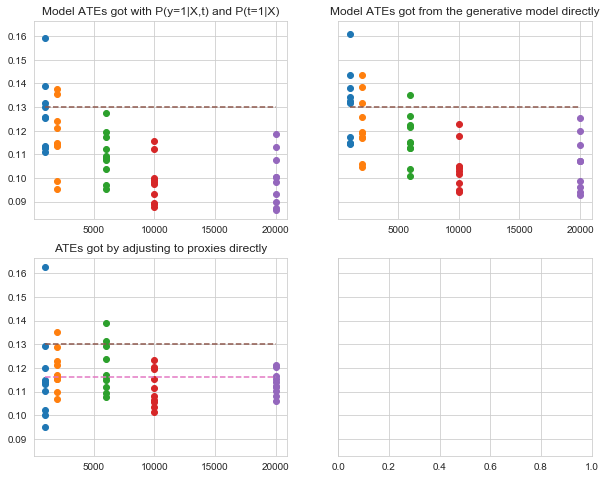

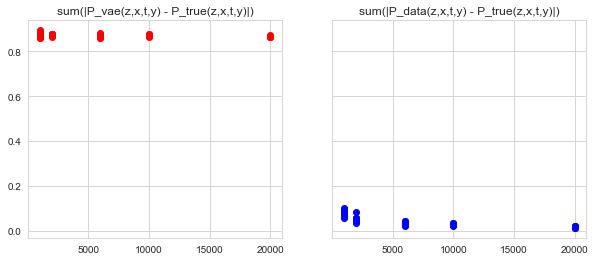

In [740]:
"""Plot results"""
fig, ax = plt.subplots(2, 2, figsize=(10,8), sharey=True)
for n in range(len(datasizes)):
    ax[0,0].plot(datasize_times*[datasizes[n]], model_ATEs_1[n], 'o')
ax[0,0].plot([datasizes[0], datasizes[-1]+0.1], 2*[calculate_true_ate(prob_df)], '--')
ax[0,0].set_title("Model ATEs got with P(y=1|X,t) and P(t=1|X)")

for n in range(len(datasizes)):
    ax[0,1].plot(datasize_times*[datasizes[n]], model_ATEs_3[n], 'o')
ax[0,1].plot([datasizes[0], datasizes[-1]+0.1], 2*[calculate_true_ate(prob_df)], '--')
ax[0,1].set_title("Model ATEs got from the generative model directly")

for n in range(len(datasizes)):
    ax[1,0].plot(datasize_times*[datasizes[n]], proxy_ATEs[n], 'o')
ax[1,0].plot([datasizes[0], datasizes[-1]+0.1], 2*[calculate_true_ate(prob_df)], '--')
ax[1,0].plot([datasizes[0], datasizes[-1]+0.1], 2*[calculate_proxy_ate(prob_df)], '--')
ax[1,0].set_title("ATEs got by adjusting to proxies directly")

fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True)
for n in range(len(datasizes)):
    for i in range(len(dists_VAE[n])):
        ax[0].plot(datasizes[n], (dists_VAE[n][i].P - dists_true[n][i].P).abs().sum(), 'o', c='r')
        ax[1].plot(datasizes[n], (dists_data[n][i].P - dists_true[n][i].P).abs().sum(), 'o', c='b')
ax[0].set_title("sum(|P_vae(z,x,t,y) - P_true(z,x,t,y)|)")
ax[1].set_title("sum(|P_data(z,x,t,y) - P_true(z,x,t,y)|)")

## Thoughts
- Treat P(z) as a parameter also?
- What happens when P(z) is Gaussian again?

# Test where P(z)!=0.5 and we learn it as a parameter

In [13]:
num_samples = 10000
z_expectation = torch.Tensor([0.1])
x_expectations = torch.Tensor([[0.1,0.9],
                              [0.9,0.1]])
x_dim = len(x_expectations)
t_expectations = torch.Tensor([[0.3,0.7]])
y_expectations = torch.Tensor([[0.85,0.9,0.1,0.95]])
df = binary_data_df(num_samples, z_expectation, x_expectations, t_expectations, y_expectations)

In [14]:
"""Get the convenience function and define the corresponding dataframe"""
calculate_prob = generate_calculate_prob(z_expectation, x_expectations, t_expectations, y_expectations)
prob_df = pd.DataFrame([c + (calculate_prob(c[0], c[1:3], c[3], c[4]),) for c in itertools.product([0,1],repeat=5)], 
                       columns=['z'] + ['x{}'.format(i) for i in range(x_dim)] + ['t', 'yf', 'P'])

In [15]:
"""Calculating the true ATE and the ATE we get by adjusting just for the proxies"""
print("True and proxy based ATEs: {:.3f}, {:.3f}".format(calculate_true_ate(prob_df), 
    calculate_proxy_ate(prob_df)))

True and proxy based ATEs: 0.130, 0.116


In [16]:
"""Functions that do P(y=1|X,t) and P(y=1|t) predictions perfectly"""
%autoreload 2
p_y_xt_f = generate_p_y_xt(prob_df)
p_t_x_f = generate_p_t_x(prob_df)
q_y_xt_f = generate_q_y_xt(df)
q_t_x_f = generate_q_t_x(df)

In [24]:
"""Run this before the first time running the next cell"""
datasizes = [1000,2000,6000,10000,20000]
i = 0
j = 0
dfs3 = [[0 for j in range(10)] for i in range(len(datasizes))]
models3 = [[0 for j in range(10)] for i in range(len(datasizes))]

In [25]:
"""Runs the model for different datasets multiple times"""
%autoreload 2
BATCH_SIZE = 1000
datasize_times = 10
device = 'cpu'
#what results are we gathering?

#Simulating datasets and training models
while i < len(datasizes):
    #dfs.append([])
    #models.append([])
    while j < datasize_times:
        num_samples = datasizes[i]
        print("Training data size {}, run {}".format(num_samples, j+1))
        df = binary_data_df(num_samples, z_expectation, x_expectations, t_expectations, y_expectations)
        dataset = BinaryDataset(df)
        dataloader = BinaryDataLoader(dataset, validation_split=0.0)
        train_loader, test_loader = dataloader.get_loaders(batch_size=BATCH_SIZE)
        #dummy test loader
        test_loader, _ = BinaryDataLoader(BinaryDataset(df[:1]), validation_split=0.0).get_loaders(batch_size=1)
        #Running the model
        model = run_cevae(num_epochs=150, lr_start=0.3, lr_end=0.05,
                train_loader=train_loader, test_loader=test_loader, input_dim=2,
                plot_curves=False, print_logs=False, device=device, learn_pz=True)
    
        dfs3[i][j] = df
        models3[i][j] = model
        
        torch.save(model.state_dict(), "./dummy_data/model3_{}_{}".format(num_samples,j))
        df.to_pickle("./dummy_data/data3_{}_{}".format(num_samples,j))
        
        x = torch.Tensor(df[['x0','x1']].values).to(device)
        print("Estimated ATE: {}".format(modelITE(model, x, p_y_xt_f, p_t_x_f).mean()))
        
        j += 1
    j = 0
    i += 1

Training data size 1000, run 1
Estimated ATE: 0.06037258729338646
Training data size 1000, run 2
Estimated ATE: 0.08345131576061249
Training data size 1000, run 3
Estimated ATE: 0.13518881797790527
Training data size 1000, run 4
Estimated ATE: 0.07200326025485992
Training data size 1000, run 5
Estimated ATE: 0.08870348334312439
Training data size 1000, run 6
Estimated ATE: 0.1142318993806839
Training data size 1000, run 7
Estimated ATE: 0.07915034145116806
Training data size 1000, run 8
Estimated ATE: 0.1168426051735878
Training data size 1000, run 9
Estimated ATE: 0.13232114911079407
Training data size 1000, run 10
Estimated ATE: 0.14050640165805817
Training data size 2000, run 1
Estimated ATE: 0.1250748336315155
Training data size 2000, run 2
Estimated ATE: 0.1310959905385971
Training data size 2000, run 3
Estimated ATE: 0.13827206194400787
Training data size 2000, run 4
Estimated ATE: 0.1136372908949852
Training data size 2000, run 5
Estimated ATE: 0.11792141944169998
Training data 

In [26]:
%autoreload 2
#Calculating results from the models
model_ITEs_1 = [[] for n in range(len(datasizes))]
model_ITEs_2 = [[] for n in range(len(datasizes))]
model_ATEs_1 = [[] for n in range(len(datasizes))]
model_ATEs_2 = [[] for n in range(len(datasizes))]
model_ATEs_3 = [[] for n in range(len(datasizes))]
proxy_ITEs = [[] for n in range(len(datasizes))]
proxy_ATEs = [[] for n in range(len(datasizes))]
dists_VAE = [[] for n in range(len(datasizes))]
dists_data = [[] for n in range(len(datasizes))]
dists_true = [[] for n in range(len(datasizes))]

for n in range(len(datasizes)):
    for i in range(datasize_times):
        #P(y=1|X,t) and P(t=1|X) estimates directly from the data
        df = dfs3[n][i]
        model = models3[n][i]
        q_y_xt_f = generate_q_y_xt(df)
        q_t_x_f = generate_q_t_x(df)

        #Getting the ITE and ATE estimates
        x = torch.Tensor(df[['x0','x1']].values).to(device)
        p_y_xt_f(x[0][0].item(),x[0][1].item(),1)
        model_ITEs_1[n].append(modelITE(model, x, p_y_xt_f, p_t_x_f))
        model_ITEs_2[n].append(modelITE(model, x, q_y_xt_f, q_t_x_f))
        proxy_ITEs[n].append(proxyITE(x, q_y_xt_f))
        model_ATEs_1[n].append(model_ITEs_1[n][i].mean())
        model_ATEs_2[n].append(model_ITEs_2[n][i].mean())
        proxy_ATEs[n].append(proxy_ITEs[n][i].mean())
        z_sample = dist.Bernoulli(torch.sigmoid(model.pz_logit)).sample((50000,))
        p_y_do1_model = torch.sigmoid(model.decoder.y1_nn(z_sample)).mean()
        p_y_do0_model =torch.sigmoid(model.decoder.y0_nn(z_sample)).mean()
        model_ATEs_3[n].append(p_y_do1_model - p_y_do0_model)

        #Getting probability distribution estimates
        zs, xs, ts, ys = model.decoder.sample(1000000, torch.sigmoid(model.pz_logit))
        sample_data = torch.cat([zs, xs,ts,ys],axis=1)
        dist_VAE, dist_data, dist_true = getJointDistributions(sample_data, df[['z','x0','x1','t','yf']],prob_df)
        #Choosing the assignment for z
        dist_VAE_1 = dist_VAE
        dist_VAE_2 = dist_VAE.copy()
        dist_VAE_2.z = 1-dist_VAE_2.z
        dist_VAE_2.sort_values(by=['z','x0','x1','t','yf'], inplace=True, ignore_index=True)
        err_1 = (dist_VAE_1.P - dist_true.P).abs().sum()
        err_2 = (dist_VAE_2.P - dist_true.P).abs().sum()
        if err_1 < err_2:
            dists_VAE[n].append(dist_VAE_1)
        else:
            dists_VAE[n].append(dist_VAE_2)
        dists_data[n].append(dist_data)
        dists_true[n].append(dist_true)

Text(0.5, 1.0, 'sum(|P_data(z,x,t,y) - P_true(z,x,t,y)|)')

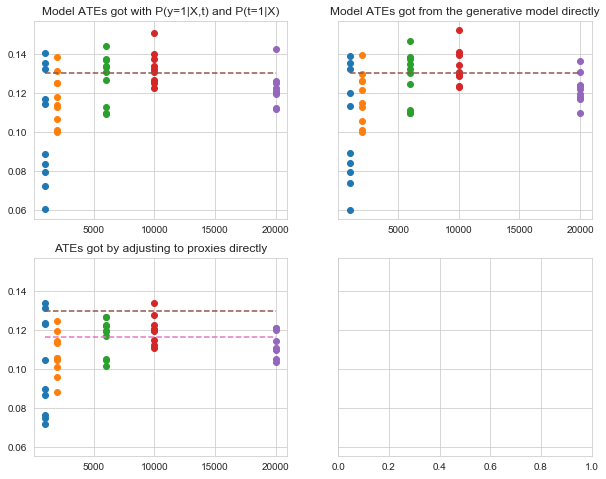

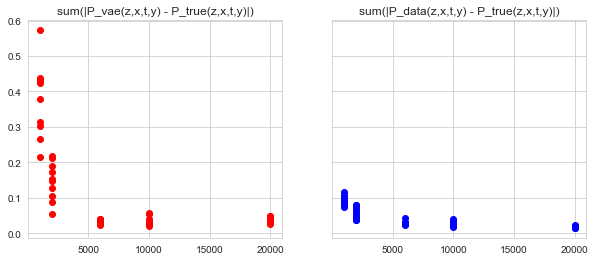

In [27]:
"""Plot results"""
fig, ax = plt.subplots(2, 2, figsize=(10,8), sharey=True)
for n in range(len(datasizes)):
    ax[0,0].plot(datasize_times*[datasizes[n]], model_ATEs_1[n], 'o')
ax[0,0].plot([datasizes[0], datasizes[-1]+0.1], 2*[calculate_true_ate(prob_df)], '--')
ax[0,0].set_title("Model ATEs got with P(y=1|X,t) and P(t=1|X)")

for n in range(len(datasizes)):
    ax[0,1].plot(datasize_times*[datasizes[n]], model_ATEs_3[n], 'o')
ax[0,1].plot([datasizes[0], datasizes[-1]+0.1], 2*[calculate_true_ate(prob_df)], '--')
ax[0,1].set_title("Model ATEs got from the generative model directly")

for n in range(len(datasizes)):
    ax[1,0].plot(datasize_times*[datasizes[n]], proxy_ATEs[n], 'o')
ax[1,0].plot([datasizes[0], datasizes[-1]+0.1], 2*[calculate_true_ate(prob_df)], '--')
ax[1,0].plot([datasizes[0], datasizes[-1]+0.1], 2*[calculate_proxy_ate(prob_df)], '--')
ax[1,0].set_title("ATEs got by adjusting to proxies directly")

fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True)
for n in range(len(datasizes)):
    for i in range(len(dists_VAE[n])):
        ax[0].plot(datasizes[n], (dists_VAE[n][i].P - dists_true[n][i].P).abs().sum(), 'o', c='r')
        ax[1].plot(datasizes[n], (dists_data[n][i].P - dists_true[n][i].P).abs().sum(), 'o', c='b')
ax[0].set_title("sum(|P_vae(z,x,t,y) - P_true(z,x,t,y)|)")
ax[1].set_title("sum(|P_data(z,x,t,y) - P_true(z,x,t,y)|)")

# Free-form testing

In [713]:
num_samples = 10000
z_expectation = torch.Tensor([0.1])
x_expectations = torch.Tensor([[0.1,0.9],
                              [0.9,0.1]])
x_dim = len(x_expectations)
t_expectations = torch.Tensor([[0.3,0.7]])
y_expectations = torch.Tensor([[0.85,0.9,0.1,0.95]])
df = binary_data_df(num_samples, z_expectation, x_expectations, t_expectations, y_expectations)

In [714]:
"""Get the convenience function and define the corresponding dataframe"""
calculate_prob = generate_calculate_prob(z_expectation, x_expectations, t_expectations, y_expectations)
prob_df = pd.DataFrame([c + (calculate_prob(c[0], c[1:3], c[3], c[4]),) for c in itertools.product([0,1],repeat=5)], 
                       columns=['z'] + ['x{}'.format(i) for i in range(x_dim)] + ['t', 'yf', 'P'])

In [715]:
"""Functions that do P(y=1|X,t) and P(y=1|t) predictions perfectly"""
%autoreload 2
p_y_xt_f = generate_p_y_xt(prob_df)
p_t_x_f = generate_p_t_x(prob_df)
q_y_xt_f = generate_q_y_xt(df)
q_t_x_f = generate_q_t_x(df)

In [716]:
"""Calculating the true ATE and the ATE we get by adjusting just for the proxies"""
print("True and proxy based ATEs: {:.3f}, {:.3f}".format(calculate_true_ate(prob_df), 
    calculate_proxy_ate(prob_df)))

True and proxy based ATEs: 0.130, 0.116


In [717]:
%autoreload 2
BATCH_SIZE = 1000
device = 'cpu'
dataset = BinaryDataset(df)
dataloader = BinaryDataLoader(dataset, validation_split=0.0)
train_loader, test_loader = dataloader.get_loaders(batch_size=BATCH_SIZE)
#dummy test loader
test_loader, _ = BinaryDataLoader(BinaryDataset(df[:1]), validation_split=0.0).get_loaders(batch_size=1)

Training Results - Epoch 1 - y_reconc_loss: 458.3580 x_reconc_loss: 815.9202 t_reconc_loss: 616.8801 kld_loss: 157.6438 total_loss: 2048.8021 learning rate: 0.2935
Training Results - Epoch 2 - y_reconc_loss: 422.0773 x_reconc_loss: 807.0325 t_reconc_loss: 608.3333 kld_loss: 144.9333 total_loss: 1982.3763 learning rate: 0.2871
Training Results - Epoch 3 - y_reconc_loss: 389.5636 x_reconc_loss: 713.5597 t_reconc_loss: 605.6646 kld_loss: 238.5459 total_loss: 1947.3338 learning rate: 0.2809
Training Results - Epoch 4 - y_reconc_loss: 389.6310 x_reconc_loss: 687.4725 t_reconc_loss: 595.5050 kld_loss: 251.8814 total_loss: 1924.4898 learning rate: 0.2748
Training Results - Epoch 5 - y_reconc_loss: 393.2153 x_reconc_loss: 610.1551 t_reconc_loss: 612.1914 kld_loss: 300.8564 total_loss: 1916.4182 learning rate: 0.2688
Training Results - Epoch 6 - y_reconc_loss: 392.0871 x_reconc_loss: 591.8490 t_reconc_loss: 618.0354 kld_loss: 306.6479 total_loss: 1908.6193 learning rate: 0.2629
Training Results

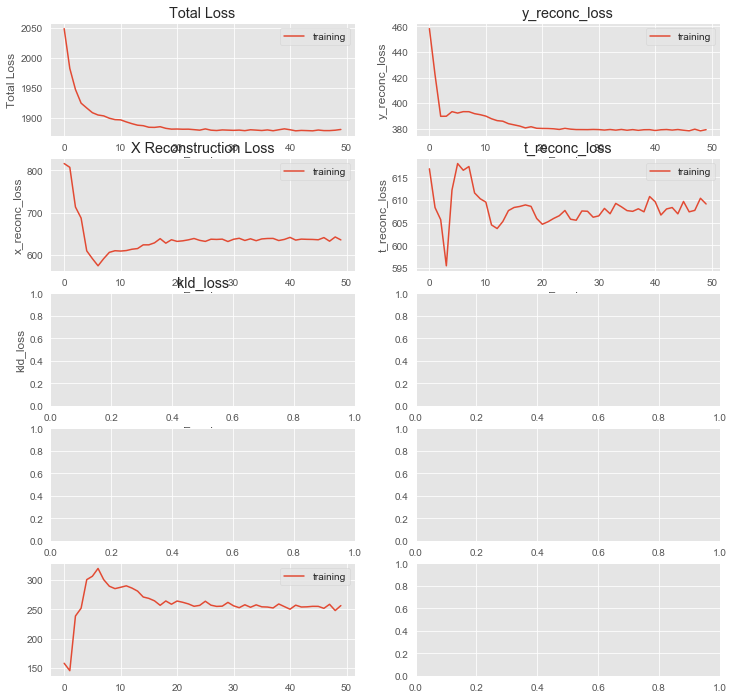

In [718]:
%autoreload 2
model = run_cevae(num_epochs=50, lr_start=0.3, lr_end=0.1,
                  train_loader=train_loader, test_loader=test_loader, input_dim=2,
                 plot_curves=True, print_logs=True, learn_pz=True, device="cpu")

In [724]:
x = torch.Tensor(df[['x0','x1']].values)
print(modelITE(model, x, p_y_xt_f, p_t_x_f).mean())

z_sample = dist.Bernoulli(torch.sigmoid(model.pz_logit)).sample((50000,))
p_y_do1_model = torch.sigmoid(model.decoder.y1_nn(z_sample)).mean()
p_y_do0_model =torch.sigmoid(model.decoder.y0_nn(z_sample)).mean()
print(p_y_do1_model-p_y_do0_model)

tensor(0.1256, grad_fn=<MeanBackward0>)
tensor(0.1210, grad_fn=<SubBackward0>)


0.09212075396874564

tensor([0.7843], grad_fn=<SigmoidBackward>)
P(z=1|x0:0,x1:0,t:0,y:0)	0.8610304980990452	0.08411217088585166
P(z=1|x0:0,x1:0,t:0,y:1)	0.9771644824446156	0.005464482250322708
P(z=1|x0:0,x1:0,t:1,y:0)	0.8495053214844471	0.11111111820852235
P(z=1|x0:0,x1:0,t:1,y:1)	0.3781767551497956	0.5044247582308709
P(z=1|x0:0,x1:1,t:0,y:0)	0.9953488144013494	0.001132503423519874
P(z=1|x0:0,x1:1,t:0,y:1)	0.9994117936027269	6.782884041725017e-05
P(z=1|x0:0,x1:1,t:1,y:0)	0.9957594619925308	0.0015408326742528484
P(z=1|x0:0,x1:1,t:1,y:1)	0.9772148890441731	0.012410192080781795
P(z=1|x0:1,x1:0,t:0,y:0)	0.08835655991896733	0.881499378332467
P(z=1|x0:1,x1:0,t:0,y:1)	0.4043931334387843	0.30798478111280053
P(z=1|x0:1,x1:0,t:1,y:0)	0.07628049873635441	0.9101123499974817
P(z=1|x0:1,x1:0,t:1,y:1)	0.009024316895300123	0.9880162590423297
P(z=1|x0:1,x1:1,t:0,y:0)	0.8708516715560657	0.08411216241238434
P(z=1|x0:1,x1:1,t:0,y:1)	0.9790592447882865	0.005464481989605953
P(z=1|x0:1,x1:1,t:1,y:0)	0.8549970544434061	0.1111111

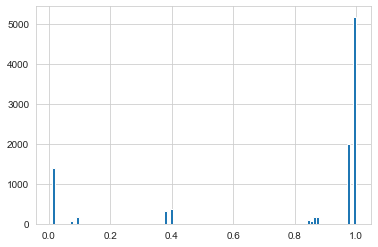

In [657]:
"""TODO: write code that tests the encoder in some way. Ideas:
-Is the conditional distribution that it models correct?
    -Need to get the conditional distribution from the data (generating process) and the model
-Plot some new stuff during training time.
-Check the ITE calculation again in case it is wrong"""
x = torch.Tensor(df[['x0','x1']].values)
t = torch.Tensor(df[['t']].values)
y = torch.Tensor(df[['yf']].values)
#dfs3[4][0][['x0','x1']].values
plt.hist(torch.sigmoid(model.encoder(x,t,y)[2]).detach().numpy(), bins=100)

def pz_given(x0,x1,t,yf):
    return prob_df[(prob_df.z==1)&(prob_df.x0==x0)&(prob_df.x1==x1)&(prob_df.t==t)&(prob_df.yf==yf)].P.sum() \
            / prob_df[(prob_df.x0==x0)&(prob_df.x1==x1)&(prob_df.t==t)&(prob_df.yf==yf)].P.sum()
print(torch.sigmoid(model.pz_logit))

for (x0,x1,t,y) in itertools.product([0,1], repeat=4):
    xt, tt, yt = torch.cat([torch.Tensor([[x0]]), torch.Tensor([[x1]])], 1), torch.Tensor([[t]]), torch.Tensor([[y]])
    encoder_prob = torch.sigmoid(model.encoder(xt,tt,yt)[2]).item()
    print("P(z=1|x0:{},x1:{},t:{},y:{})\t{}\t{}".format(x0,x1,t,y,encoder_prob,pz_given(x0,x1,t,y)))

In [198]:
def _prepare_batch(batch):
    x = batch['X'].to(device)
    t = batch['t'].to(device)
    yf = batch['yf'].to(device)
    if len(x.shape) == 1:#Temporary, making sure that shapes are bs x dim
        x = x[:,None]
        yf = yf[:,None]
        t = t[:,None]
    return x, t, yf

def kld_loss_bernoulli(logits, prior=0.5):
    # Assumes that the prior p(z=1) = 0.5
    probs = torch.sigmoid(logits)
    #kld = -(torch.log(probs) + torch.log(1-probs) - 2*np.log(0.5)).sum()
    kld = (probs*torch.log(probs/prior) + (1-probs)*torch.log((1-probs)/(1-prior))).sum()
    return kld

"""Testing the optimization procedure"""
optimizer = Adam(model.parameters(), lr=0.1)

In [268]:

for batch in train_loader:
    x, t, yf = _prepare_batch(batch)
    (z_logits, x_logits0, x_logits1, t_logits0, 
             t_logits1, y_logits0, y_logits1, pz_logit) = model(x,t,yf)
    optimizer.zero_grad()
    kld = kld_loss_bernoulli(z_logits, prior=torch.sigmoid(pz_logit))
    z_probs = torch.sigmoid(z_logits)
    t_loss = -(z_probs*dist.Bernoulli(logits=t_logits1).log_prob(t) + 
                (1-z_probs)*dist.Bernoulli(logits=t_logits0).log_prob(t)).sum()
    yf_loss = -(z_probs*dist.Bernoulli(logits=y_logits1).log_prob(yf) + 
                (1-z_probs)*dist.Bernoulli(logits=y_logits0).log_prob(yf)).sum()
    x_loss = -(z_probs*dist.Bernoulli(logits=x_logits1).log_prob(x) + 
                (1-z_probs)*dist.Bernoulli(logits=x_logits0).log_prob(x)).sum()
    tr_loss = x_loss + t_loss + yf_loss + kld
    tr_loss.backward()
    optimizer.step()
    print(tr_loss)

tensor(1966.2356, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1924.3913, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1978.1708, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1971.6271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1949.2959, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1943.2719, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1968.1165, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1873.6696, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1843.4486, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1872.9930, dtype=torch.float64, grad_fn=<AddBackward0>)


tensor([0.7490], grad_fn=<SigmoidBackward>)
P(z=1|x0:0,x1:0,t:0,y:0)	0.9627679815173285	0.9599999911696836
P(z=1|x0:0,x1:0,t:0,y:1)	0.9852399307112067	0.9818181754041154
P(z=1|x0:0,x1:0,t:1,y:0)	0.09555018779351682	0.07692311366163761
P(z=1|x0:0,x1:0,t:1,y:1)	0.3164562632285494	0.28358209201111506
P(z=1|x0:0,x1:1,t:0,y:0)	0.253866155266181	0.2285714342030078
P(z=1|x0:0,x1:1,t:0,y:1)	0.4746907779381085	0.3999999862026317
P(z=1|x0:0,x1:1,t:1,y:0)	0.001437071581314072	0.0010277500247772215
P(z=1|x0:0,x1:1,t:1,y:1)	0.006702310618792873	0.004863067841783608
P(z=1|x0:1,x1:0,t:0,y:0)	0.9995459771708585	0.9994858608359459
P(z=1|x0:1,x1:0,t:0,y:1)	0.9997944879701522	0.9997714284210029
P(z=1|x0:1,x1:0,t:1,y:0)	0.894522765465058	0.8709677537802593
P(z=1|x0:1,x1:0,t:1,y:1)	0.9713333395464633	0.9697542438527904
P(z=1|x0:1,x1:1,t:0,y:0)	0.9707179553284883	0.9599999867545224
P(z=1|x0:1,x1:1,t:0,y:1)	0.9881386331962361	0.9818181759172394
P(z=1|x0:1,x1:1,t:1,y:0)	0.10539735820861854	0.07692311162061452

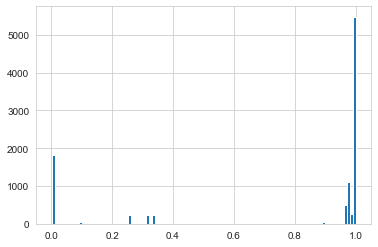

In [269]:
x = torch.Tensor(df[['x0','x1']].values)
t = torch.Tensor(df[['t']].values)
y = torch.Tensor(df[['yf']].values)
#dfs3[4][0][['x0','x1']].values
plt.hist(torch.sigmoid(model.encoder(x,t,y)[2]).detach().numpy(), bins=100)

def pz_given(x0,x1,t,yf):
    return prob_df[(prob_df.z==1)&(prob_df.x0==x0)&(prob_df.x1==x1)&(prob_df.t==t)&(prob_df.yf==yf)].P.sum() \
            / prob_df[(prob_df.x0==x0)&(prob_df.x1==x1)&(prob_df.t==t)&(prob_df.yf==yf)].P.sum()
print(torch.sigmoid(model.pz_logit))

for (x0,x1,t,y) in itertools.product([0,1], repeat=4):
    xt, tt, yt = torch.cat([torch.Tensor([[x0]]), torch.Tensor([[x1]])], 1), torch.Tensor([[t]]), torch.Tensor([[y]])
    encoder_prob = torch.sigmoid(model.encoder(xt,tt,yt)[2]).item()
    print("P(z=1|x0:{},x1:{},t:{},y:{})\t{}\t{}".format(x0,x1,t,y,encoder_prob,pz_given(x0,x1,t,y)))

In [176]:
z_sample = dist.Bernoulli(torch.sigmoid(model.pz_logit)).sample((50000,))
p_y_do1_model = torch.sigmoid(model.decoder.y1_nn(z_sample)).mean()
p_y_do0_model =torch.sigmoid(model.decoder.y0_nn(z_sample)).mean()
p_y_do1_model - p_y_do0_model

tensor(0.7232, device='cuda:0', grad_fn=<SubBackward0>)

In [175]:
torch.sigmoid(model.pz_logit)

tensor([0.7428], device='cuda:0', grad_fn=<SigmoidBackward>)

In [173]:
torch.Tensor([0.5]).to("cuda")

tensor([0.5000], device='cuda:0')

In [101]:
%autoreload 2
zs, xs, ts, ys = model.decoder.sample(20000)

In [104]:
print("Marginal probs according to VAE and according to the data")

sample_data = torch.cat([xs,ts,ys],axis=1)
printCombinations(sample_data, df[['x0','x1','t','yf']],prob_df)

sample_data = torch.cat([ts,ys],axis=1)
printCombinations(sample_data, df[['t','yf']],prob_df)

sample_data = torch.cat([ts,ys,zs],axis=1)
printCombinations(sample_data, df[['t','yf','z']],prob_df)

Marginal probs according to VAE and according to the data
P(x0=0,x1=0,t=0,yf=0)	0.0375(VAE)	=0.0389(data)	0.0365(true)
P(x0=0,x1=0,t=0,yf=1)	0.00935(VAE)	=0.0067(data)	0.0086(true)
P(x0=0,x1=0,t=1,yf=0)	0.00905(VAE)	=0.0085(data)	0.0083(true)
P(x0=0,x1=0,t=1,yf=1)	0.03555(VAE)	=0.0355(data)	0.0367(true)
P(x0=0,x1=1,t=0,yf=0)	0.03695(VAE)	=0.0402(data)	0.0401(true)
P(x0=0,x1=1,t=0,yf=1)	0.0067(VAE)	=0.0052(data)	0.0050(true)
P(x0=0,x1=1,t=1,yf=0)	0.06975(VAE)	=0.0703(data)	0.0729(true)
P(x0=0,x1=1,t=1,yf=1)	0.29225(VAE)	=0.2937(data)	0.2921(true)
P(x0=1,x1=0,t=0,yf=0)	0.29475(VAE)	=0.291(data)	0.2920(true)
P(x0=1,x1=0,t=0,yf=1)	0.0738(VAE)	=0.0733(data)	0.0729(true)
P(x0=1,x1=0,t=1,yf=0)	0.00415(VAE)	=0.0031(data)	0.0029(true)
P(x0=1,x1=0,t=1,yf=1)	0.03415(VAE)	=0.036(data)	0.0421(true)
P(x0=1,x1=1,t=0,yf=0)	0.03745(VAE)	=0.039(data)	0.0364(true)
P(x0=1,x1=1,t=0,yf=1)	0.0099(VAE)	=0.0092(data)	0.0085(true)
P(x0=1,x1=1,t=1,yf=0)	0.00835(VAE)	=0.0087(data)	0.0083(true)
P(x0=1,x1=1,t=1,yf=

In [ ]:
sample_data = torch.cat([xs,ts,ys,zs],axis=1)
printCombinations(sample_data, df[['x0','x1','t','yf','z']])